scikit-opt是包含粒子群算法的python包，是蚂蚁金服一位工作人员编写的。粒子群算法对Q学习的超参数选择上，时间过长，效果不优，因此搁置。
Dyna-Q学习算法，在环境奖励不是稀疏的情况下，能够得到更快的解。
广义贝尔曼部分，

在https://github.com/indujohniisc/GSQL.git 中


在https://github.com/raghudiddigi/SOR-Q-Learning.git 中

具有编写。没有进行额外测试

# 初始化工作

In [ ]:
! git clone https://github.com/guofei9987/scikit-opt.git

Cloning into 'scikit-opt'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 1392 (delta 25), reused 27 (delta 14), pack-reused 1343
Receiving objects: 100% (1392/1392), 302.62 KiB | 8.18 MiB/s, done.
Resolving deltas: 100% (950/950), done.


In [ ]:
! mv scikit-opt/* . 

In [ ]:
import gym
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Q学习算法

## 智能体

In [ ]:
class agent_q_learning():
  def __init__(self, env, q_param):
    self.env = env
    if q_param is None:
      self.alpha = 0.1
      self.gamma = 0.9
    else:
      self.alpha = q_param['alpha']
      self.gamma =  q_param['gamma']
    self.epsilon = 0.1

    self.q={}
    self.__init_q_table()
    pass

  def output_action(self, state, is_greedy = True):
    if random.uniform(0,1) < self.epsilon and is_greedy:
      return self.env.action_space.sample()
    else:
      return max(list(range(self.env.action_space.n)) ,
                 key=lambda x: self.q[(state,x)])
    pass

  def __init_q_table(self):
    for s in range(self.env.observation_space.n):
      for a in range(self.env.action_space.n):
        self.q[(s,a)]=0.0

  def update_q_table(self, state, action, next_state, next_maxaction, reward):
    self.q[(state,action)] += self.alpha * \
                            (reward + \
                             self.gamma * self.q[(next_state,next_maxaction)] - \
                             self.q[(state,action)] \
                             )


## 执行类

In [ ]:
class evaluate_alg_q():
  def __init__(self, env, cnt=50, episodes=2000, q_param=None):
    #cnt 用作多次求平均值
    self.env = env
    self.cnt = cnt
    self.episodes = episodes
    self.q_param = q_param
    self.reward_array = np.zeros(episodes)
    pass

  def start_execute(self):
    for _ in tqdm(range(self.cnt)):
      self.agent = agent_q_learning(self.env, self.q_param)
      for i in range(self.episodes):
        r = 0
        state = self.env.reset()
        while True:
          action = self.agent.output_action(state)

          next_state, reward, done , _ = self.env.step(action)

          next_maxaction = self.agent.output_action(state, is_greedy=False)

          self.agent.update_q_table(state, action, next_state, next_maxaction, reward)

          state = next_state
          r += reward

          if done:
              break
        self.reward_array[i] += r
      self.reward_array[i] /= self.cnt

  def evaluate_plot_reward(self):
    plt.plot(self.reward_array,'-')
  
  def evaluate_plot_reward_dev(self, dev_num=10,style='-'):
    size_row = int(len(self.reward_array)/dev_num)
    reward_array_dev = self.reward_array.reshape((size_row, dev_num)).mean(axis = 1)
    envaluate_plt = plt.plot(reward_array_dev, style)
    return envaluate_plt

## 执行

In [ ]:
env=gym.make('FrozenLake-v0')
q_param = {'alpha':1, 'gamma':0.9}
algorithm_q = evaluate_alg_q(env, cnt=5, episodes=10000, q_param=q_param)
algorithm_q.start_execute()
# algorithm_q.evaluate_plot_reward()
env.close()

100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


In [ ]:
env=gym.make('Taxi-v3')
q_param = {'alpha':1, 'gamma':1}
algorithm_q = evaluate_alg_q(env, cnt=5, episodes=2000, q_param=q_param)
algorithm_q.start_execute()
# algorithm_q.evaluate_plot_reward()
env.close()

100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


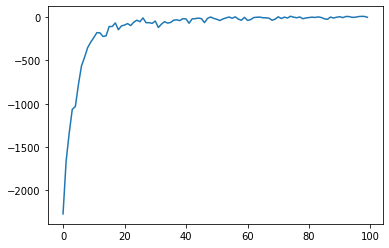

In [ ]:
algorithm_q.evaluate_plot_reward_dev(dev_num=20)

# 定义粒子群（待定）

In [ ]:
def demo_func(x):
  env=gym.make('Taxi-v3')
  x1, x2 = x
  param = {'alpha':x1, 'gamma':x2}
  algorithm_q = evaluate_alg_q(env, cnt=1, episodes=2000, q_param=param)
  algorithm_q.start_execute()
  env.close()
  fit_value = algorithm_q.reward_array[:-500].mean()
  return fit_value

In [ ]:
from sko.PSO import PSO

pso = PSO(func=demo_func, n_dim=2, pop=5, max_iter=10, lb=[-1, 0.6], ub=[1, 2], w=0.8, c1=0.5, c2=0.5)
pso.run()
print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)

100%|██████████| 1/1 [00:08<00:00,  8.35s/it]


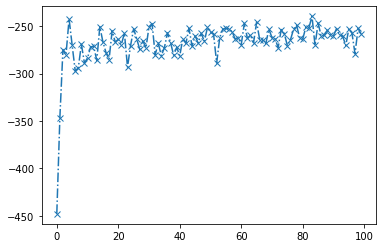

In [ ]:
env=gym.make('Taxi-v3')
param = {'alpha':0.001, 'gamma':0.01}
algorithm_q = evaluate_alg_q(env, cnt=1, episodes=2000, q_param=param)
algorithm_q.start_execute()
env.close()
algorithm_q.evaluate_plot_reward_dev(20,style='x-.')

In [ ]:
algorithm_q.agent.alpha

0.001

In [ ]:
algorithm_q.agent.gamma

0.01

# Dyna算法综合

## 记忆模型

In [ ]:
class dyna_memory:
  def __init__(self, env, memory_length=20000, memory_minibatch=1):
    self.env = env
    self.memory_length = memory_length
    self.memory_minibatch = memory_minibatch

    try:self.state_size = self.env.observation_space.shape[0]
    except:self.state_size = 1
    try:self.action_size = self.env.action_space.shape[0]
    except:self.action_size = 1
    
    self.memory_width = self.state_size * 2 + self.action_size + 1
    self.memory = np.zeros((self.memory_length, self.memory_width))

    self.index = 0
    self.max_index = 0

  def store(self, state, action, reward, next_state):
    transacton = np.hstack((state, action, reward, next_state))
    self.memory[self.index,:] = transacton

    self.index += 1
    if self.index % self.memory_length == 0:
      self.index = 0
    if self.max_index < self.memory_length:
      self.max_index += 1
  
  def sample(self):
    choice_random = np.random.choice(self.max_index, self.memory_minibatch)
    choice_data = self.memory[choice_random,:]
    state = choice_data[:,0:self.state_size]
    action = choice_data[:,self.state_size:self.state_size+self.action_size]
    reward = choice_data[:,self.state_size+self.action_size:
                         self.state_size+self.action_size+1]
    next_state = choice_data[:,self.state_size+self.action_size+1:]

    reward = np.squeeze(reward)
    if self.action_size == 1:
      action = np.squeeze(action)
      action = int(action)
    if self.state_size == 1:
      state = np.squeeze(state)
      next_state = np.squeeze(next_state)
      state = int(state)
      next_state = int(next_state)

    return state, action, reward, next_state


## 执行类

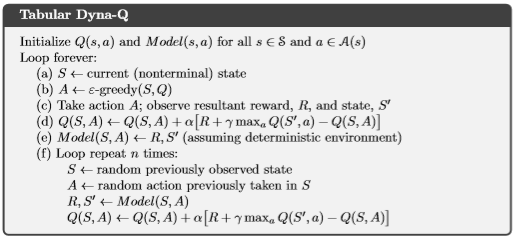

In [ ]:
class evaluate_dyna_q():
  def __init__(self, env, cnt=50, episodes=2000, q_param=None):
    #cnt 用作多次求平均值
    self.env = env
    self.cnt = cnt
    self.episodes = episodes
    self.q_param = q_param
    self.reward_array = np.zeros(episodes)

    self.dyna_memory = dyna_memory(self.env)
    pass

  def start_execute(self):
    for _ in tqdm(range(self.cnt)):
      self.agent = agent_q_learning(self.env, self.q_param)
      for i in range(self.episodes):
        r = 0
        state = self.env.reset()
        while True:
          action = self.agent.output_action(state)
          next_state, reward, done , _ = self.env.step(action)
          self.dyna_memory.store(state, action, reward, next_state)
          
          next_maxaction = self.agent.output_action(state, is_greedy=False)
          self.agent.update_q_table(state, action, next_state, next_maxaction, reward)
          state = next_state
          r += reward
          if done:
              break
          for i in range(3):
            model_state, model_action, model_reward, model_next_state = self.dyna_memory.sample()
            model_action_max = self.agent.output_action(model_state, is_greedy=False)
            self.agent.update_q_table(model_state, model_action,
                                      model_next_state, model_action_max, model_reward)


        self.reward_array[i] += r
      self.reward_array[i] /= self.cnt

  def evaluate_plot_reward(self):
    plt.plot(self.reward_array,'-')
  
  def evaluate_plot_reward_dev(self, dev_num=10,style='-'):
    size_row = int(len(self.reward_array)/dev_num)
    reward_array_dev = self.reward_array.reshape((size_row, dev_num)).mean(axis = 1)
    envaluate_plt = plt.plot(reward_array_dev, style)
    return envaluate_plt

## 执行

In [ ]:
# FrozenLake-v0
# Taxi-v3
env=gym.make('FrozenLake-v0')
q_param = {'alpha':1, 'gamma':0.9}
algorithm_dyna_q = evaluate_dyna_q(env, cnt=5, episodes=10000, q_param=q_param)
algorithm_dyna_q.start_execute()

env.close()



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:25<01:43, 25.84s/it]

 40%|████      | 2/5 [00:51<01:17, 25.82s/it]

 60%|██████    | 3/5 [01:17<00:51, 25.73s/it]

 80%|████████  | 4/5 [01:43<00:25, 25.80s/it]

100%|██████████| 5/5 [02:08<00:00, 25.79s/it]


In [ ]:
algorithm_dyna_q.evaluate_plot_reward_dev(1,style='x-.')
algorithm_q.evaluate_plot_reward_dev(dev_num=1)
plt.legend(['dyna q', 'q learning'])

# 广义贝尔曼尝试

## 智能体

# 执行类